# 利用 gplearn 进行特征工程

featuretools有专门的 transfrom 类的特征处理方式，但是我在实际使用中没有使用，因为featuretool的思路是凡是能够进行特征变换的特征都要应用一遍，所以应用的模式基本上是生成大量的性能不强的特征，下一步必须进行严格的。

是时候试试gplearn这个库了。

gplearn是Python内最成熟的符号回归算法实现，作为一种一种监督学习方法，符号回归（symbolic regression）试图发现某种隐藏的数学公式，以此利用特征变量预测目标变量。

符号回归的具体实现方式是遗传算法（genetic algorithm）。一开始，一群天真而未经历选择的公式会被随机生成。此后的每一代中，最「合适」的公式们将被选中。随着迭代次数的增长，它们不断繁殖、变异、进化，从而不断逼近数据分布的真相。

- [汉语介绍](https://zhuanlan.zhihu.com/p/31185882)
- [官方文档](http://gplearn.readthedocs.io/en/stable/index.html)

当然我这里不是想尝试符号回归的机器学习方式，而是符号回归的机器学习方式提供了另外一种生成特征的思路，在库中通过Symbolic Transformer 类进行有关特征工程相关操作。

本文还是以 [Home Credit Default Risk](https://www.kaggle.com/c/home-credit-default-risk)这个项目进行说明。

在手工特征工程中，我们会对两个或者多个特征进行一些 加减乘除的操作，来生成一些特征，希望能够生成一些
例如在[start-here-a-gentle-introduction](https://www.kaggle.com/willkoehrsen/start-here-a-gentle-introduction)的这篇kernel中，
根据领域的先验知识，对金额特征, 日期特征进行比值操作生成一些特征，这些特征经常能够提升验证集和测试集的分数，在模型中也有很高的重要程度。
```
app_test_domain['DAYS_EMPLOYED_PERCENT'] = app_test_domain['DAYS_EMPLOYED'] / app_test_domain['DAYS_BIRTH']
```


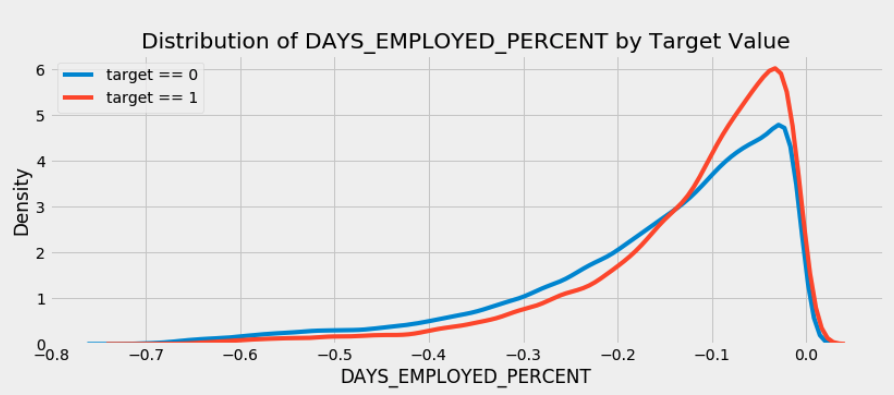

![](https://ws4.sinaimg.cn/large/006tKfTcgy1ft3p2xnp35j30po0cvq4l.jpg)

但毕竟领域的先验知识是有限的，我们有时候也没有足够的先验知识，同时自己进行特征组合也经常费时费力，自己生成的大量特征不是都有足够的重要性，还需要进一步筛选。

gplearn这个库提供了解决的思路：
- 随机化生成大量特征组合方式，解决了没有先验知识，手工生成特征费时费力的问题
- 通过遗传算法进行特征组合的迭代，而且这种迭代是有监督的迭代，存留的特征和label相关性是也来越高的，大量低相关特征组合会在迭代中被淘汰掉，用决策树算法做个类比的话，我们自己组合特征然后筛选，好比是后剪枝过程，遗传算法进行的则是预剪枝的方式。


变异的方式有兴趣的可以看看文档 [变异](http://gplearn.readthedocs.io/en/stable/intro.html#evolution)，具体遗传算法的方式我只是看看思路，并没有仔细推导。

官方给出的 [例子](http://gplearn.readthedocs.io/en/stable/examples.html#example-2-symbolic-transformer) 是用 sklearn中自带的波士顿房价数据来进行特征组合，但是只是给出了一个新生成的特征缺失提升了测试集的效果的结论。

所以，尝试还是用官方的数据，探索一下新生成的特征到底表现如何。

从一下几个方面考察：

- 特征和label的相关性
- 特征之间的共线性
- 特征在模型中的重要程度
- 特征对模型性能的提升



官方例子中，使用的是Ridge回归，使用 r2_score 评价回归效果。在生成10个特征后，0.7591提升至0.8417。

In [1]:
import numpy as np
import pandas as pd
np.random.seed(7)
pd.set_option('display.max_columns', None)

import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns

from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from gplearn.genetic import SymbolicTransformer
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, r2_score, make_scorer

import warnings
warnings.filterwarnings('ignore')

# 1 控制实验

In [2]:
def data_prepare():
    boston = load_boston()
    boston_feature = pd.DataFrame(boston.data, columns=boston.feature_names)
    boston_label = pd.Series(boston.target).to_frame("TARGET")

    boston = pd.concat([boston_label, boston_feature], axis=1)
    
    return boston

data = data_prepare()
print(data.shape)

(506, 14)


2 15


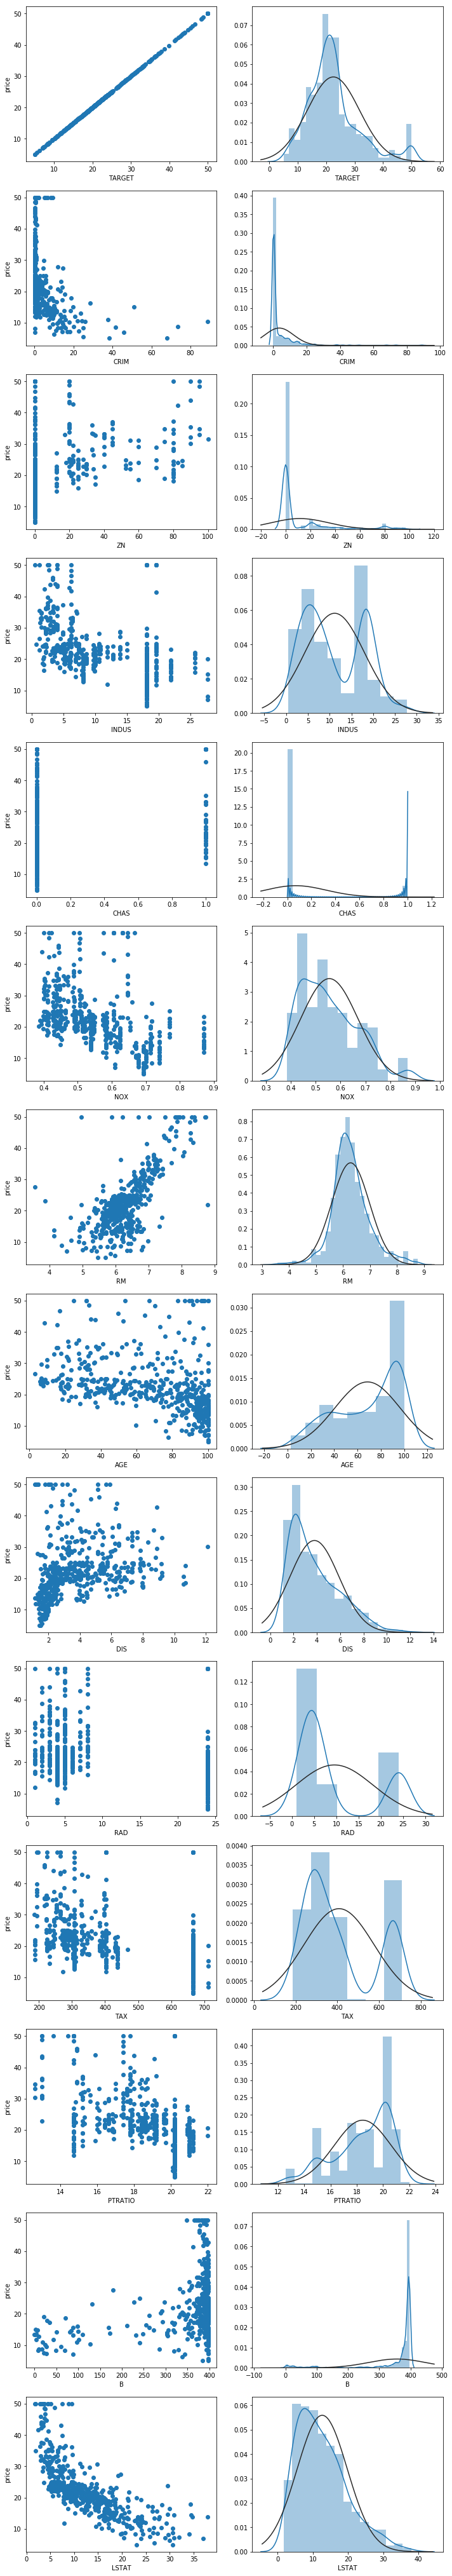

In [3]:
# 查看现有特征分布

def plot_dist(df, feature, pic_name='dist_plot.png'):
    fcols = 2
    frows = len(feature) + 1
    print(fcols, frows)
    plt.figure(figsize=(5*fcols, 4*frows))

    i = 0
    for col in feature:
        
        i += 1
        ax = plt.subplot(frows, fcols, i)

        plt.scatter(df[col], df['TARGET'])

        plt.xlabel(col)
        plt.ylabel('price')

        i += 1
        ax = plt.subplot(frows, fcols, i)
        sns.distplot(df[col].dropna(), fit=stats.norm)
        plt.xlabel(col)

    plt.tight_layout()
    
plot_dist(data, data.columns)

In [4]:
# 使用log1p变换将特征基本拉到一个尺度进行建模
for col in data.columns.drop('TARGET'):
    data[col] = np.log1p(data[col])

2 15


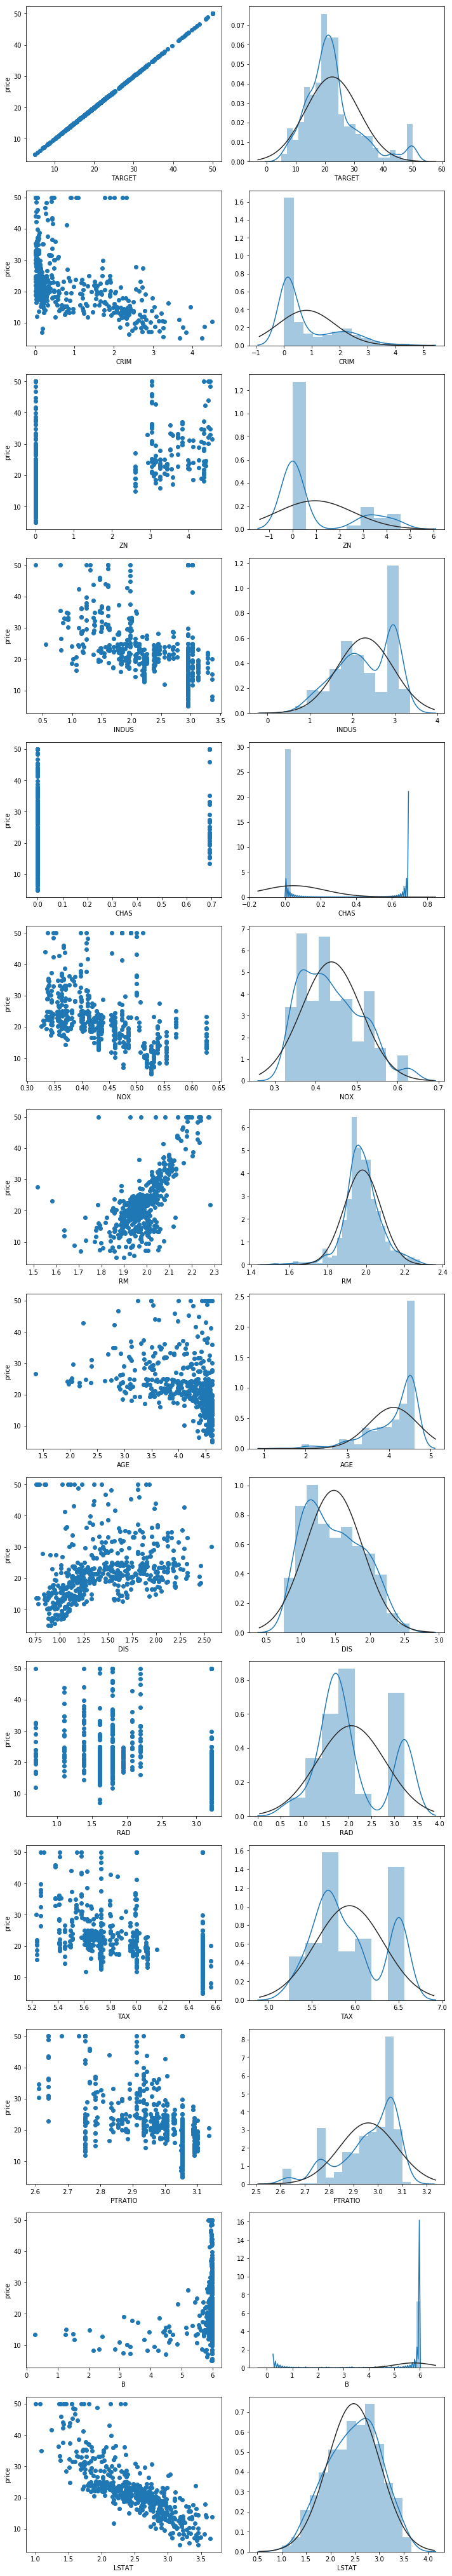

In [5]:
# 观察新的特征的分布
plot_dist(data, data.columns)

In [6]:
corr = data.corr('spearman')
corr

,TARGET,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
TARGET,1.000000,-0.557032,0.438179,-0.578255,0.140612,-0.562609,0.633576,-0.547562,0.445857,-0.346776,-0.562411,-0.555905,0.185664,-0.852914
CRIM,-0.557032,1.000000,-0.571586,0.735409,0.042337,0.820355,-0.310738,0.703673,-0.744381,0.726496,0.728157,0.464386,-0.358463,0.632969
ZN,0.438179,-0.571586,1.000000,-0.642811,-0.041937,-0.634828,0.361074,-0.544423,0.614627,-0.278767,-0.371394,-0.448475,0.163135,-0.490074
INDUS,-0.578255,0.735409,-0.642811,1.000000,0.089841,0.791189,-0.415301,0.679487,-0.757080,0.455507,0.664361,0.433710,-0.285840,0.638747
CHAS,0.140612,0.042337,-0.041937,0.089841,1.000000,0.068426,0.058813,0.067792,-0.080248,0.024579,-0.044486,-0.136065,-0.039810,-0.050575
NOX,-0.562609,0.820355,-0.634828,0.791189,0.068426,1.000000,-0.310344,0.795153,-0.880015,0.586429,0.649527,0.391309,-0.296662,0.636828
RM,0.633576,-0.310738,0.361074,-0.415301,0.058813,-0.310344,1.000000,-0.278082,0.263168,-0.107492,-0.271898,-0.312923,0.053660,-0.640832
AGE,-0.547562,0.703673,-0.544423,0.679487,0.067792,0.795153,-0.278082,1.000000,-0.801610,0.417983,0.526366,0.355384,-0.228022,0.657071
DIS,0.445857,-0.744381,0.614627,-0.757080,-0.080248,-0.880015,0.263168,-0.801610,1.000000,-0.495806,-0.574336,-0.322041,0.249595,-0.564262
RAD,-0.346776,0.726496,-0.278767,0.455507,0.024579,0.586429,-0.107492,0.417983,-0.495806,1.000000,0.704876,0.318330,-0.282533,0.394322


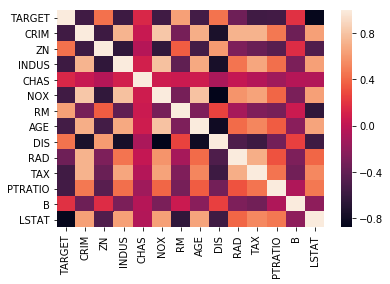

In [7]:
sns.heatmap(corr)

In [8]:
threshold = 0.85
correlated_pairs= {}
for col in corr:
    # Find correlations above the threshold
    above_threshold_vars = [x for x in list(corr.index[abs(corr[col]) > threshold]) if x != col]
    correlated_pairs[col] = above_threshold_vars

In [9]:
correlated_pairs

{'TARGET': ['LSTAT'],
 'CRIM': [],
 'ZN': [],
 'INDUS': [],
 'CHAS': [],
 'NOX': ['DIS'],
 'RM': [],
 'AGE': [],
 'DIS': ['NOX'],
 'RAD': [],
 'TAX': [],
 'PTRATIO': [],
 'B': [],
 'LSTAT': ['TARGET']}

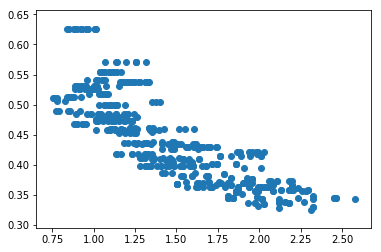

In [10]:
plt.scatter(data['DIS'], data['NOX'])

特征LSTAT 和 target 相关性较高， DIS 和 NOX 两个特征相关性较高,可视化展示一下

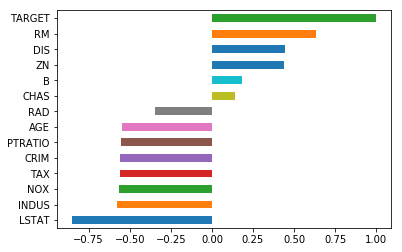

In [11]:
corr['TARGET'].sort_values().plot.barh()

## 原始特征的建模

In [12]:
features = data.columns.drop('TARGET') 

In [13]:
x_train, x_test, y_train, y_test = train_test_split(data[features], data['TARGET'].to_frame(),
                                                        test_size=0.3, shuffle=True)

In [14]:
def Preds(x, y, x_test, y_test, alpha, n_splits=4, random_state=23, verbose=0):
    feature_importance = pd.DataFrame(columns=['feature', 'importance', 'fold'])

    folds = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    oof_preds, sub_preds = np.zeros(x.shape[0]), np.zeros(x_test.shape[0])

    oof_train = np.zeros(x.shape[0])

    if verbose > 0:
        print(x.shape, x_test.shape)

    train_scores = []
    valid_scores = []
    test_scores = []


    for n_fold, (trn_idx, val_idx) in enumerate(folds.split(x, y)):
        trn_x, trn_y = x.iloc[trn_idx, :], y.iloc[trn_idx, :]
        val_x, val_y = x.iloc[val_idx, :], y.iloc[val_idx, :]

        # print(type(trn_x.values), type(trn_y.values), type(val_x.values), type(val_y.values))
        #
        # print(trn_x.shape, trn_y.shape)
        # print(val_x.shape, val_y.values.ravel().shape)

        model = Ridge(alpha=alpha) 
        model.fit(trn_x.values, trn_y.values.ravel())

        trn_preds = model.predict(trn_x)
        val_preds = model.predict(val_x)
        test_preds = model.predict(x_test)

        oof_preds[val_idx] = val_preds
        sub_preds += test_preds/folds.n_splits

        train_score = mean_squared_error(trn_y, trn_preds)
        val_score = mean_squared_error(val_y, val_preds)
        test_score = mean_squared_error(y_test, test_preds)

        train_scores.append(train_score)
        valid_scores.append(val_score)
        test_scores.append(test_score)

        feature_importance = feature_importance.append(pd.DataFrame({
            'importance': model.coef_,
            'fold': [n_fold + 1] * x.shape[1],
            'feature': x.columns.tolist()
        }))

  
    feature_importance['importance'] = feature_importance['importance'].astype(float)

    fi = feature_importance.groupby(['feature']).agg(['mean'])['importance'].sort_values(by=['mean'], ascending=False)

    fold_names = list(range(folds.n_splits))
    fold_names.append('overall')

    valid_mse = mean_squared_error(y, oof_preds)

    valid_scores.append(valid_mse)
    train_scores.append(np.mean(train_scores))
    test_scores.append(np.mean(test_scores))

    # 构建记录分数的 Dataframe
    metrics = pd.DataFrame({'fold': fold_names,
                            'train': train_scores,
                            'valid': valid_scores,
                            'test': test_scores})

    oof_preds = pd.Series(oof_preds.flatten(), index=x.index).rename('TARGET')
    sub_preds = pd.Series(sub_preds.flatten(), index=x_test.index).rename('TARGET')

    return metrics, fi

In [15]:
alphas = [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1]
for alpha in alphas:
    metrics, fi = Preds(x_train, y_train, x_test, y_test, alpha)
    print('\n{}'.format(alpha))
    print(metrics)

# 验证集上 0.01最优
metrics, fi = Preds(x_train, y_train, x_test, y_test, 0.01)


0.001
      fold      train      valid       test
0        0  18.864104  15.746318  20.610661
1        1  15.827233  24.263691  19.985034
2        2  17.189420  20.303606  18.718604
3        3  17.686227  18.233910  18.263533
4  overall  17.391746  19.638961  19.394458

0.005
      fold      train      valid       test
0        0  18.864486  15.723581  20.586877
1        1  15.827482  24.273101  19.971926
2        2  17.189786  20.303409  18.707088
3        3  17.686564  18.241307  18.253575
4  overall  17.392080  19.637400  19.379867

0.01
      fold      train      valid       test
0        0  18.865634  15.696148  20.557963
1        1  15.828226  24.284637  19.955849
2        2  17.190880  20.304150  18.693556
3        3  17.687572  18.251201  18.241885
4  overall  17.393078  19.636047  19.362313

0.05
      fold      train      valid       test
0        0  18.894710  15.508640  20.352260
1        1  15.846889  24.367471  19.836119
2        2  17.217775  20.339201  18.610641
3     

In [16]:
fi

,mean
feature,
RM,23.382444
CHAS,3.675033
RAD,2.957648
B,1.149737
AGE,0.357166
ZN,0.059264
INDUS,-1.032948
CRIM,-1.052022
TAX,-3.640124


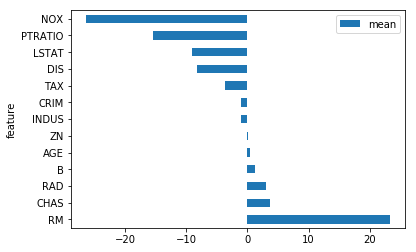

In [17]:
fi.plot.barh()

# 2 实验一

## 构建新特征

In [18]:
function_set = ['add', 'sub', 'mul', 'div', 'log', 'sqrt', 'abs', 'neg', 'max', 'min']

gp1 = SymbolicTransformer(generations=10, population_size=1000,
                         hall_of_fame=100, n_components=10,
                         function_set=function_set,
                         parsimony_coefficient=0.0005,
                         max_samples=0.9, verbose=1,
                         random_state=0, n_jobs=3)

train_idx = x_train.index
test_idx = x_test.index

gp1.fit(x_train, y_train)

    |    Population Average   |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0    13.25 0.35215820538843834        4 0.8399642120921131 0.8631399792968668      6.13s
   1     7.74 0.6509047122446647        4 0.854811198891366 0.6134145793047867      8.93s
   2      5.1 0.7451984248444017        6 0.8650752905834724 0.878227274155125      8.18s
   3     7.03 0.7518979416328959        7 0.8763431104252732 0.7951335487059465      7.45s
   4     7.16 0.7591796481159598       10 0.8828326949307452 0.7073734924607572      6.24s
   5     7.81 0.759856605512581       10 0.8903082052010824 0.596763132843551      5.00s
   6     7.34 0.7444249802274013        8 0.8933633108969566 0.714507353176865      3.72s
   7     7.39 0.7559044930589053        8 0.8965955942175357 0.6962367478463342      2.44s
   8     6.92 0.749407424511992

SymbolicTransformer(const_range=(-1.0, 1.0),
          function_set=['add', 'sub', 'mul', 'div', 'log', 'sqrt', 'abs', 'neg', 'max', 'min'],
          generations=10, hall_of_fame=100, init_depth=(2, 6),
          init_method='half and half', max_samples=0.9, metric='pearson',
          n_components=10, n_jobs=3, p_crossover=0.9,
          p_hoist_mutation=0.01, p_point_mutation=0.01,
          p_point_replace=0.05, p_subtree_mutation=0.01,
          parsimony_coefficient=0.0005, population_size=1000,
          random_state=0, stopping_criteria=1.0, tournament_size=20,
          verbose=1, warm_start=False)

In [19]:
print(gp1)

[div(min(X5, X5), add(X10, X12)),
 sub(-0.988, div(min(X5, X5), log(div(X5, add(X10, X12))))),
 div(X5, add(X10, add(X10, X12))),
 div(div(X5, add(X10, X12)), add(X10, X12)),
 div(log(log(div(X5, add(X10, X12)))), add(X10, X12)),
 div(X5, log(sqrt(add(X10, X12)))),
 div(sqrt(div(X5, add(X10, X12))), add(X10, X12)),
 div(X5, add(add(X10, X12), X12)),
 log(div(X5, add(X10, X12))),
 div(div(X5, add(X10, X12)), log(div(sub(div(X5, add(X10, X12)), min(X5, X5)), add(X10, X12))))]


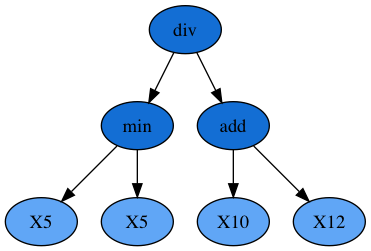

In [20]:
from IPython.display import Image
import pydotplus
graph = gp1._best_programs[0].export_graphviz()
graph = pydotplus.graphviz.graph_from_dot_data(graph)
Image(graph.create_png())

可视化特征组合的方式，可以看到随机性是很强的，这个图示左子树其实没什么鸟用。。

In [21]:
gp_train_feature = gp1.transform(x_train)
gp_test_feature = gp1.transform(x_test)

new_feature_name = [str(i)+'V' for i in range(1, 11)]
train_new_feature = pd.DataFrame(gp_train_feature, columns=new_feature_name, index=train_idx)
test_new_feature = pd.DataFrame(gp_test_feature, columns=new_feature_name, index=test_idx)

In [22]:
x_train_0 = pd.concat([x_train, train_new_feature], axis=1)
x_test_0 = pd.concat([x_test, test_new_feature], axis=1)

new_x_data = pd.concat([x_train_0, x_test_0], axis=0)
new_data = pd.concat([data['TARGET'], new_x_data], axis=1)

In [23]:
new_data.columns

Index(['TARGET', 'CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS',
       'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT', '1V', '2V', '3V', '4V', '5V',
       '6V', '7V', '8V', '9V', '10V'],
      dtype='object')

### 新特征的分布

2 11


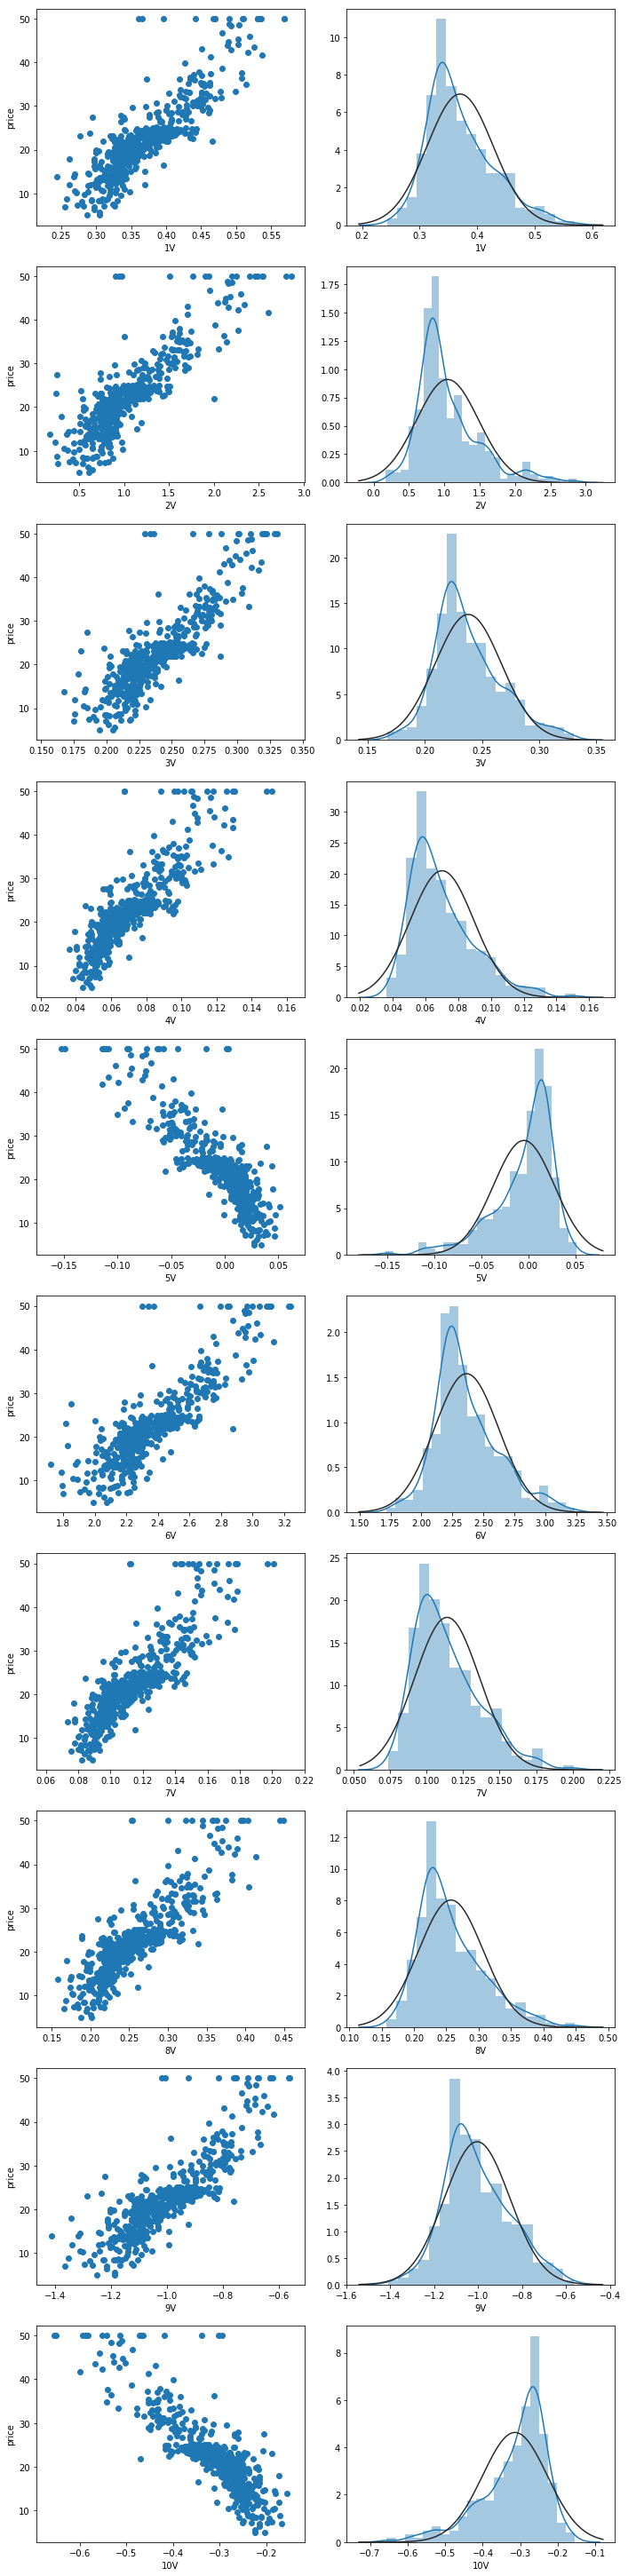

In [24]:
plot_dist(new_data, new_feature_name)

### 相关性

In [25]:
new_corr = new_data.corr('spearman')

In [26]:
new_corr

,TARGET,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,1V,2V,3V,4V,5V,6V,7V,8V,9V,10V
TARGET,1.000000,-0.557032,0.438179,-0.578255,0.140612,-0.562609,0.633576,-0.547562,0.445857,-0.346776,-0.562411,-0.555905,0.185664,-0.852914,0.860760,0.831370,0.851298,0.870853,-0.856905,0.841034,0.872339,0.860702,0.860760,-0.858390
CRIM,-0.557032,1.000000,-0.571586,0.735409,0.042337,0.820355,-0.310738,0.703673,-0.744381,0.726496,0.728157,0.464386,-0.358463,0.632969,-0.608798,-0.560346,-0.596039,-0.631067,0.605200,-0.574858,-0.636844,-0.614354,-0.608798,0.603731
ZN,0.438179,-0.571586,1.000000,-0.642811,-0.041937,-0.634828,0.361074,-0.544423,0.614627,-0.278767,-0.371394,-0.448475,0.163135,-0.490074,0.515195,0.496038,0.519972,0.522433,-0.514665,0.502560,0.524323,0.506824,0.515195,-0.513073
INDUS,-0.578255,0.735409,-0.642811,1.000000,0.089841,0.791189,-0.415301,0.679487,-0.757080,0.455507,0.664361,0.433710,-0.285840,0.638747,-0.636452,-0.606435,-0.624598,-0.647182,0.634210,-0.617046,-0.649468,-0.639397,-0.636452,0.633855
CHAS,0.140612,0.042337,-0.041937,0.089841,1.000000,0.068426,0.058813,0.067792,-0.080248,0.024579,-0.044486,-0.136065,-0.039810,-0.050575,0.068970,0.063478,0.078355,0.070837,-0.066838,0.063532,0.070837,0.063105,0.068970,-0.068277
NOX,-0.562609,0.820355,-0.634828,0.791189,0.068426,1.000000,-0.310344,0.795153,-0.880015,0.586429,0.649527,0.391309,-0.296662,0.636828,-0.598750,-0.557065,-0.575474,-0.617590,0.596815,-0.570430,-0.622209,-0.610196,-0.598750,0.594549
RM,0.633576,-0.310738,0.361074,-0.415301,0.058813,-0.310344,1.000000,-0.278082,0.263168,-0.107492,-0.271898,-0.312923,0.053660,-0.640832,0.781473,0.864433,0.806493,0.720509,-0.788822,0.843991,0.696073,0.761261,0.781473,-0.792906
AGE,-0.547562,0.703673,-0.544423,0.679487,0.067792,0.795153,-0.278082,1.000000,-0.801610,0.417983,0.526366,0.355384,-0.228022,0.657071,-0.600422,-0.548232,-0.568915,-0.625786,0.597325,-0.564432,-0.632834,-0.617647,-0.600422,0.594566
DIS,0.445857,-0.744381,0.614627,-0.757080,-0.080248,-0.880015,0.263168,-0.801610,1.000000,-0.495806,-0.574336,-0.322041,0.249595,-0.564262,0.531250,0.490094,0.509066,0.548261,-0.529366,0.502774,0.551673,0.542098,0.531250,-0.527314
RAD,-0.346776,0.726496,-0.278767,0.455507,0.024579,0.586429,-0.107492,0.417983,-0.495806,1.000000,0.704876,0.318330,-0.282533,0.394322,-0.364927,-0.315621,-0.354298,-0.390779,0.360011,-0.329203,-0.397841,-0.369379,-0.364927,0.358563


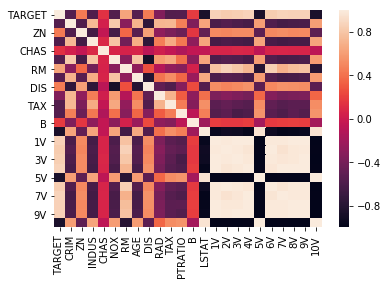

In [27]:
sns.heatmap(new_corr)

### 与标签的相关性

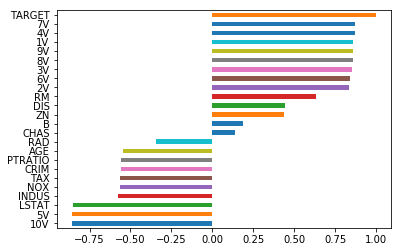

In [28]:
new_corr['TARGET'].sort_values().plot.barh()

新特征与label的相关性都很高

### 特征之间的相关性

In [29]:
new_features_corr = new_data[new_feature_name].corr('spearman')

In [30]:
new_features_corr

,1V,2V,3V,4V,5V,6V,7V,8V,9V,10V
1V,1.000000,0.985936,0.992656,0.993647,-0.999698,0.992173,0.987874,0.996708,1.000000,-0.999694
2V,0.985936,1.000000,0.987176,0.963609,-0.988340,0.998843,0.952545,0.977956,0.985936,-0.989170
3V,0.992656,0.987176,1.000000,0.981191,-0.992998,0.991081,0.973690,0.980354,0.992656,-0.993462
4V,0.993647,0.963609,0.981191,1.000000,-0.991638,0.973799,0.998879,0.994279,0.993647,-0.991120
5V,-0.999698,-0.988340,-0.992998,-0.991638,1.000000,-0.993977,-0.985284,-0.996067,-0.999698,0.999801
6V,0.992173,0.998843,0.991081,0.973799,-0.993977,1.000000,0.964023,0.985442,0.992173,-0.994528
7V,0.987874,0.952545,0.973690,0.998879,-0.985284,0.964023,1.000000,0.989929,0.987874,-0.984604
8V,0.996708,0.977956,0.980354,0.994279,-0.996067,0.985442,0.989929,1.000000,0.996708,-0.995796
9V,1.000000,0.985936,0.992656,0.993647,-0.999698,0.992173,0.987874,0.996708,1.000000,-0.999694
10V,-0.999694,-0.989170,-0.993462,-0.991120,0.999801,-0.994528,-0.984604,-0.995796,-0.999694,1.000000


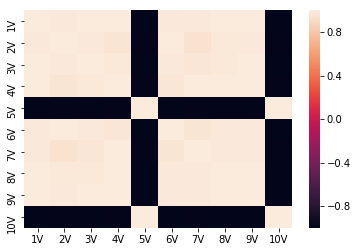

In [31]:
sns.heatmap(new_features_corr)

新特征之间的相关性很高, 都在0.95以上 

In [32]:
alphas = [1e-4, 5e-4, 0.001, 0.005, 0.01, 0.05, 0.1, 0.3, 0.5, 0.7, 1]
for alpha in alphas:
    metrics, fi = Preds(x_train_0, y_train, x_test_0, y_test, alpha)
    print('\n{}'.format(alpha))
    print(metrics)

# 验证集上 0.001最优
metrics, fi = Preds(x_train_0, y_train, x_test_0, y_test, 0.001)


0.0001
      fold      train      valid       test
0        0  13.369107  11.072057  20.916616
1        1  10.285711  20.308492  20.674107
2        2  11.710076  15.521096  19.277636
3        3  13.157046  11.280359  19.954781
4  overall  12.130485  14.551969  20.205785

0.0005
      fold      train      valid       test
0        0  13.572276  10.615586  20.043746
1        1  10.414223  20.029625  19.986788
2        2  11.849488  15.542570  18.720108
3        3  13.355882  10.830006  19.110325
4  overall  12.297967  14.260482  19.465242

0.001
      fold      train      valid       test
0        0  13.716057  10.485317  19.684615
1        1  10.505336  20.059070  19.679700
2        2  11.941672  15.593777  18.474792
3        3  13.531627  10.720574  18.730045
4  overall  12.423673  14.220659  19.142288

0.005
      fold      train      valid       test
0        0  14.120487  10.415669  19.145468
1        1  10.769325  20.271181  19.151490
2        2  12.250513  15.629213  17.968045
3 

In [33]:
fi

,mean
feature,
RM,86.159792
5V,81.812936
2V,40.091015
3V,9.333319
CHAS,3.189768
RAD,2.946542
1V,1.112475
B,0.870658
ZN,0.088915


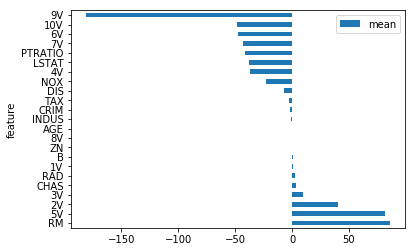

In [34]:
fi.plot.barh()

1 3 5 相对重要程度较小， 2 4 重要程度较高， 但是都没有超过原来的特征

In [35]:
metrics

,fold,train,valid,test
0,0,13.716057,10.485317,19.684615
1,1,10.505336,20.059070,19.679700
2,2,11.941672,15.593777,18.474792
3,3,13.531627,10.720574,18.730045
4,overall,12.423673,14.220659,19.142288


对比元特征训练的 mse分数，val 19.636047  test 19.362313 性能基本没变化

## 结论

在这个例子中，实际上模型效果没有提升，主要原因感觉是生成的特征属性较为单一，遗传算法最终的目标都是拟合label，导致特征之间相关性太高。

感觉可以适当降低遗传算法的轮数，保存特征的多样性，降低特征之间的相关性。

# 3 实验二

将遗传代数减低至一代进行模型构建

In [36]:
function_set = ['add', 'sub', 'mul', 'div', 'log', 'sqrt', 'abs', 'neg', 'max', 'min']  # 

gp2 = SymbolicTransformer(generations=1, population_size=1000,
                         hall_of_fame=100, n_components=10,
                         function_set=function_set,
                         parsimony_coefficient=0.0005,
                         max_samples=0.9, verbose=1,
                         random_state=0, n_jobs=3)

train_idx = x_train.index
test_idx = x_test.index

gp2.fit(x_train, y_train)

    |    Population Average   |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0    13.25 0.35215820538843834        4 0.8399642120921131 0.8631399792968668      0.00s


SymbolicTransformer(const_range=(-1.0, 1.0),
          function_set=['add', 'sub', 'mul', 'div', 'log', 'sqrt', 'abs', 'neg', 'max', 'min'],
          generations=1, hall_of_fame=100, init_depth=(2, 6),
          init_method='half and half', max_samples=0.9, metric='pearson',
          n_components=10, n_jobs=3, p_crossover=0.9,
          p_hoist_mutation=0.01, p_point_mutation=0.01,
          p_point_replace=0.05, p_subtree_mutation=0.01,
          parsimony_coefficient=0.0005, population_size=1000,
          random_state=0, stopping_criteria=1.0, tournament_size=20,
          verbose=1, warm_start=False)

In [37]:
print(gp2)

[log(add(X10, X12)),
 sub(div(0.767, min(X10, sub(X4, add(X12, X12)))), X5),
 min(X9, add(X7, X12)),
 max(sqrt(add(sqrt(X2), neg(X12))), neg(log(log(X11)))),
 div(X9, X5),
 mul(add(add(add(abs(X12), sqrt(X7)), div(mul(X2, X4), max(X11, X8))), div(sub(min(X0, X7), min(X11, X9)), max(sqrt(X7), sqrt(X8)))), max(min(min(sqrt(X3), div(X6, X9)), sub(sqrt(X9), log(X3))), max(sqrt(neg(-0.854)), sqrt(max(X1, X5))))),
 sub(max(0.518, X5), div(X4, X7)),
 mul(max(sqrt(sub(add(X7, X2), sqrt(X1))), add(neg(sub(X5, X0)), log(sqrt(X3)))), add(abs(min(sqrt(X6), log(X7))), add(sqrt(log(0.291)), sqrt(abs(X12))))),
 add(X10, X4),
 mul(abs(sub(log(X12), abs(X0))), sub(add(sub(X12, X1), min(X1, X5)), mul(div(X4, X10), sub(X5, X4))))]


In [38]:
gp_train_feature_1 = gp2.transform(x_train)
gp_test_feature_1 = gp2.transform(x_test)

new_feature_name_W = [str(i)+'W' for i in range(1, 11)]
train_new_feature_1 = pd.DataFrame(gp_train_feature_1, columns=new_feature_name_W, index=train_idx)
test_new_feature_1 = pd.DataFrame(gp_test_feature_1, columns=new_feature_name_W, index=test_idx)

2 11


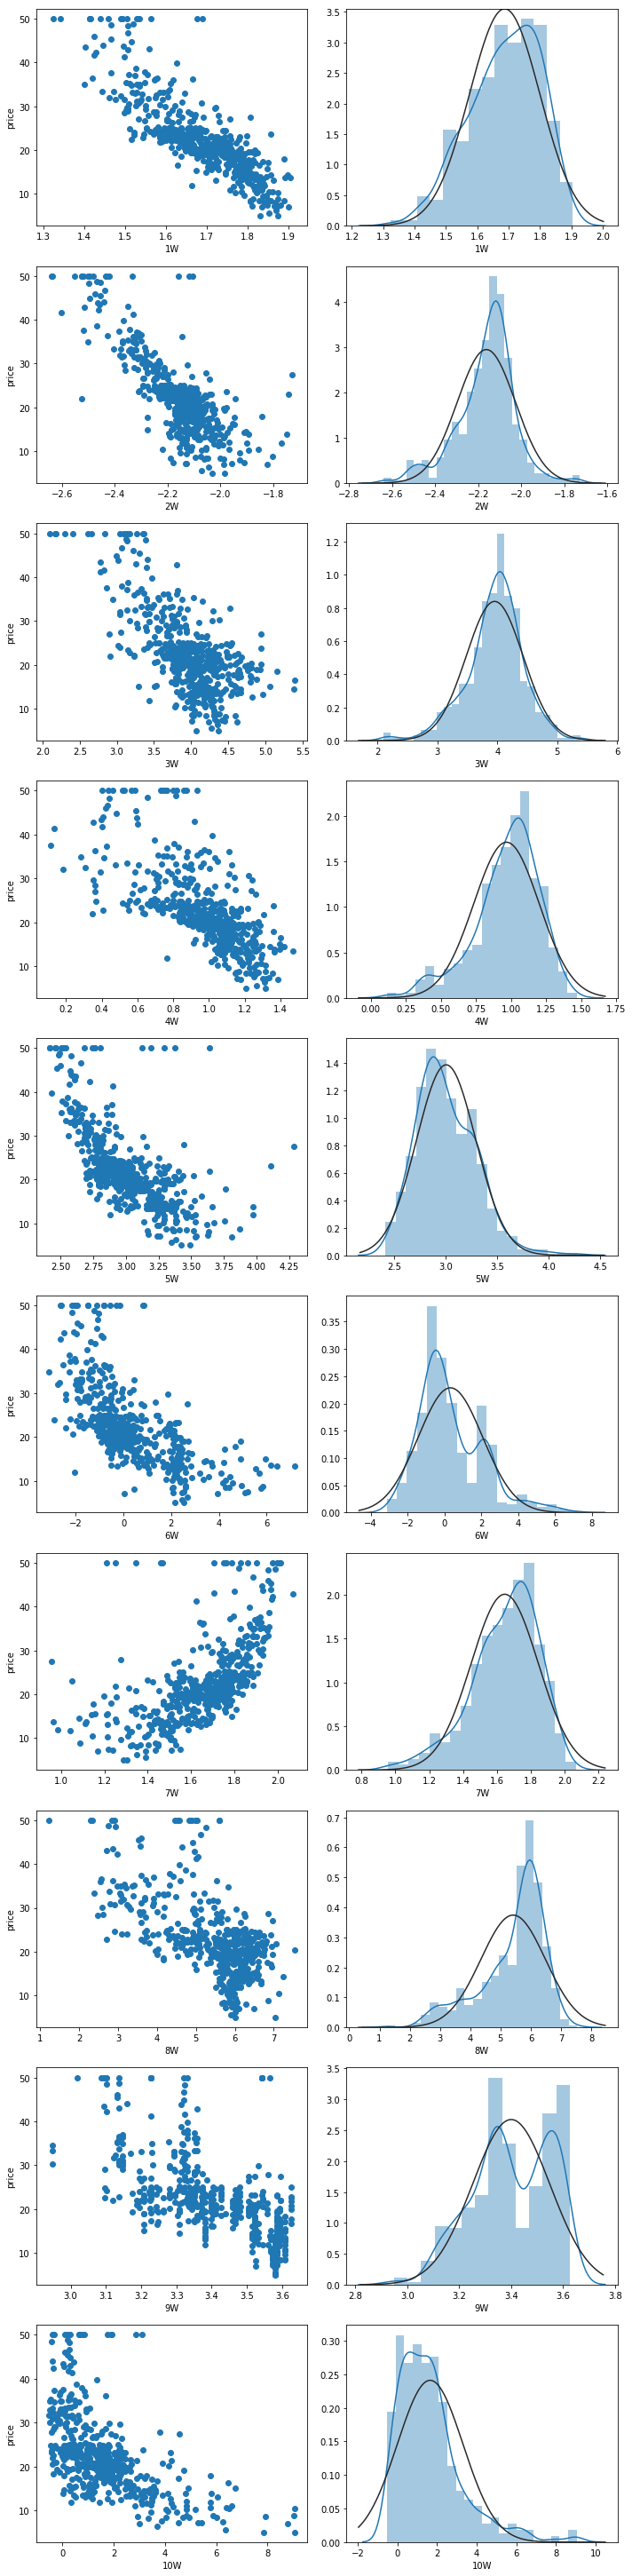

In [39]:
train_new_feature_1 = pd.concat([x_train, train_new_feature_1], axis=1)
test_new_feature_1 = pd.concat([x_test, test_new_feature_1], axis=1)

new_data_1 = pd.concat([train_new_feature_1, test_new_feature_1], axis=0)
new_data_1 = pd.concat([new_data_1, data['TARGET']], axis=1)

plot_dist(new_data_1, new_feature_name_W)

In [40]:
new_corr_1 = new_data_1.corr('spearman')

In [41]:
new_corr_1

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,1W,2W,3W,4W,5W,6W,7W,8W,9W,10W,TARGET
CRIM,1.000000,-0.571586,0.735409,0.042337,0.820355,-0.310738,0.703673,-0.744381,0.726496,0.728157,0.464386,-0.358463,0.632969,0.644425,0.432450,0.102597,0.420331,0.722308,0.761961,-0.752719,0.455808,0.686215,0.601433,-0.557032
ZN,-0.571586,1.000000,-0.642811,-0.041937,-0.634828,0.361074,-0.544423,0.614627,-0.278767,-0.371394,-0.448475,0.163135,-0.490074,-0.525903,-0.427051,-0.002462,-0.279212,-0.456032,-0.400874,0.627144,-0.725907,-0.593104,-0.671067,0.438179
INDUS,0.735409,-0.642811,1.000000,0.089841,0.791189,-0.415301,0.679487,-0.757080,0.455507,0.664361,0.433710,-0.285840,0.638747,0.648625,0.512054,0.079878,0.303114,0.698903,0.577586,-0.807914,0.583436,0.672561,0.598592,-0.578255
CHAS,0.042337,-0.041937,0.089841,1.000000,0.068426,0.058813,0.067792,-0.080248,0.024579,-0.044486,-0.136065,-0.039810,-0.050575,-0.069184,-0.058839,-0.110027,-0.079528,-0.060332,-0.013943,-0.017996,-0.017676,-0.047411,-0.016556,0.140612
NOX,0.820355,-0.634828,0.791189,0.068426,1.000000,-0.310344,0.795153,-0.880015,0.586429,0.649527,0.391309,-0.296662,0.636828,0.628623,0.436120,-0.027573,0.405013,0.664311,0.628202,-0.863321,0.387673,0.715402,0.589321,-0.562609
RM,-0.310738,0.361074,-0.415301,0.058813,-0.310344,1.000000,-0.278082,0.263168,-0.107492,-0.271898,-0.312923,0.053660,-0.640832,-0.638812,-0.962174,-0.531784,-0.580582,-0.642376,-0.499228,0.659321,-0.496719,-0.379275,-0.460080,0.633576
AGE,0.703673,-0.544423,0.679487,0.067792,0.795153,-0.278082,1.000000,-0.801610,0.417983,0.526366,0.355384,-0.228022,0.657071,0.643586,0.425247,0.074648,0.513164,0.538018,0.544168,-0.753003,0.307391,0.574308,0.567293,-0.547562
DIS,-0.744381,0.614627,-0.757080,-0.080248,-0.880015,0.263168,-0.801610,1.000000,-0.495806,-0.574336,-0.322041,0.249595,-0.564262,-0.556126,-0.378336,0.202212,-0.356656,-0.581232,-0.451723,0.851416,-0.224907,-0.602163,-0.594439,0.445857
RAD,0.726496,-0.278767,0.455507,0.024579,0.586429,-0.107492,0.417983,-0.495806,1.000000,0.704876,0.318330,-0.282533,0.394322,0.411282,0.203925,0.044939,0.237892,0.623521,0.666089,-0.481738,0.194030,0.514125,0.482478,-0.346776
TAX,0.728157,-0.371394,0.664361,-0.044486,0.649527,-0.271898,0.526366,-0.574336,0.704876,1.000000,0.453345,-0.329843,0.534423,0.558187,0.371547,0.152904,0.351962,0.888386,0.668160,-0.639342,0.316588,0.640012,0.520360,-0.562411


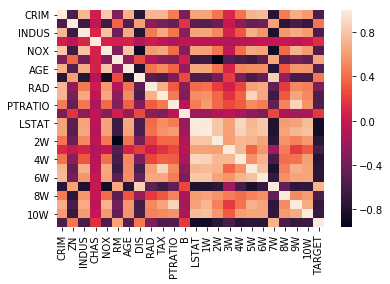

In [42]:
sns.heatmap(new_corr_1)

空值遗传1代(那不就是没有遗传) 这样的相关性才变低一点

In [43]:
alphas = [0.001, 0.005, 0.01, 0.05, 0.1, 0.3, 0.5, 0.7, 1]
for alpha in alphas:
    metrics, fi = Preds(train_new_feature_1, y_train, test_new_feature_1, y_test, alpha)
    print('\n{}'.format(alpha))
    print(metrics)

# 验证集上 0.01最优
metrics, fi = Preds(train_new_feature_1, y_train, test_new_feature_1, y_test, 0.01)


0.001
      fold      train      valid       test
0        0  13.083016  13.898016  17.130943
1        1  10.289091  26.500780  17.658644
2        2  12.441054  14.388280  16.102329
3        3  12.847393  12.907754  16.873503
4  overall  12.165139  16.942214  16.941355

0.005
      fold      train      valid       test
0        0  13.219887  13.083972  17.060925
1        1  10.314399  26.237782  17.558741
2        2  12.506805  14.351796  16.073050
3        3  12.886257  13.167058  16.773006
4  overall  12.231837  16.726823  16.866431

0.01
      fold      train      valid       test
0        0  13.407300  12.753712  17.150328
1        1  10.368547  25.864163  17.495224
2        2  12.626428  14.408992  16.077390
3        3  12.959124  13.426672  16.694990
4  overall  12.340350  16.628614  16.854483

0.05
      fold      train      valid       test
0        0  14.453832  13.025200  17.647436
1        1  11.110198  23.635975  17.571935
2        2  13.464708  15.313123  16.199423
3     

In [44]:
fi

,mean
feature,
RM,70.623020
5W,63.470325
4W,7.049604
PTRATIO,4.493416
B,2.842578
CHAS,2.761713
1W,2.548901
6W,2.080990
8W,1.967788


In [45]:
metrics

,fold,train,valid,test
0,0,13.407300,12.753712,17.150328
1,1,10.368547,25.864163,17.495224
2,2,12.626428,14.408992,16.077390
3,3,12.959124,13.426672,16.694990
4,overall,12.340350,16.628614,16.854483


### 结论

| 实验名 |特征数量|验证集分数|测试集分数|
| :---: |:---: |:---: |:---: |
|控制组|13|19.636047  |19.362313|
|||||
|实验一|23| 14.220659  |19.142288|
|||||
|实验二|23|16.628614	|16.854483|

实验一 和 实验二分别只是调整了遗传算法的训练代数，实验一训练了三代，生成的特征与目标相关性高，但是特征之间的相关性也很高，实验二只训练了一代其实就是没有进行遗传迭代，虽然生成的特征与目标相关性不强，但是生成的特征具有更高的复杂性，反而在更好的提升了模型的性能。

所以可以两个策略，一种是训练多代，输出少量特征；另一种是不进行遗传迭代，随机产生大量特征，综合两种特征进行建模。

所以实验三中，综合前两个实验gplearn模型生成特征的方式，看是否有模型提升效果。

# 4 实验三

In [46]:
# 新构建 符号转换对象 
gp3 = SymbolicTransformer(generations=1, population_size=1000, # 增加随机生成特征的种类
                         hall_of_fame=100, n_components=10,    # 同时增加筛选出来的特征数量
                         function_set=function_set,
                         parsimony_coefficient=0.0005,
                         max_samples=0.9, verbose=1,
                         random_state=0, n_jobs=3)

gp3.fit(x_train, y_train)

    |    Population Average   |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0    13.25 0.35215820538843834        4 0.8399642120921131 0.8631399792968668      0.00s


SymbolicTransformer(const_range=(-1.0, 1.0),
          function_set=['add', 'sub', 'mul', 'div', 'log', 'sqrt', 'abs', 'neg', 'max', 'min'],
          generations=1, hall_of_fame=100, init_depth=(2, 6),
          init_method='half and half', max_samples=0.9, metric='pearson',
          n_components=10, n_jobs=3, p_crossover=0.9,
          p_hoist_mutation=0.01, p_point_mutation=0.01,
          p_point_replace=0.05, p_subtree_mutation=0.01,
          parsimony_coefficient=0.0005, population_size=1000,
          random_state=0, stopping_criteria=1.0, tournament_size=20,
          verbose=1, warm_start=False)

In [47]:
print(gp3)

[log(add(X10, X12)),
 sub(div(0.767, min(X10, sub(X4, add(X12, X12)))), X5),
 min(X9, add(X7, X12)),
 max(sqrt(add(sqrt(X2), neg(X12))), neg(log(log(X11)))),
 div(X9, X5),
 mul(add(add(add(abs(X12), sqrt(X7)), div(mul(X2, X4), max(X11, X8))), div(sub(min(X0, X7), min(X11, X9)), max(sqrt(X7), sqrt(X8)))), max(min(min(sqrt(X3), div(X6, X9)), sub(sqrt(X9), log(X3))), max(sqrt(neg(-0.854)), sqrt(max(X1, X5))))),
 sub(max(0.518, X5), div(X4, X7)),
 mul(max(sqrt(sub(add(X7, X2), sqrt(X1))), add(neg(sub(X5, X0)), log(sqrt(X3)))), add(abs(min(sqrt(X6), log(X7))), add(sqrt(log(0.291)), sqrt(abs(X12))))),
 add(X10, X4),
 mul(abs(sub(log(X12), abs(X0))), sub(add(sub(X12, X1), min(X1, X5)), mul(div(X4, X10), sub(X5, X4))))]


In [48]:
gp4 = SymbolicTransformer(generations=3, population_size=1000, 
                         hall_of_fame=100, n_components=1,    # 生成特征生成减少到2
                         function_set=function_set,
                         parsimony_coefficient=0.0005,
                         max_samples=0.9, verbose=1,
                         random_state=0, n_jobs=3)

gp4.fit(x_train, y_train)

    |    Population Average   |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0    13.25 0.35215820538843834        4 0.8399642120921131 0.8631399792968668      1.50s
   1     7.74 0.6509047122446647        4 0.854811198891366 0.6134145793047867      0.96s
   2      5.1 0.7451984248444017        6 0.8650752905834724 0.878227274155125      0.00s


SymbolicTransformer(const_range=(-1.0, 1.0),
          function_set=['add', 'sub', 'mul', 'div', 'log', 'sqrt', 'abs', 'neg', 'max', 'min'],
          generations=3, hall_of_fame=100, init_depth=(2, 6),
          init_method='half and half', max_samples=0.9, metric='pearson',
          n_components=1, n_jobs=3, p_crossover=0.9, p_hoist_mutation=0.01,
          p_point_mutation=0.01, p_point_replace=0.05,
          p_subtree_mutation=0.01, parsimony_coefficient=0.0005,
          population_size=1000, random_state=0, stopping_criteria=1.0,
          tournament_size=20, verbose=1, warm_start=False)

In [49]:
gp_train_feature_3 = gp3.transform(x_train)
gp_test_feature_3 = gp3.transform(x_test)

new_feature_name_M = [str(i)+'M' for i in range(1, 11)]
train_new_feature_3 = pd.DataFrame(gp_train_feature_3, columns=new_feature_name_M, index=train_idx)
test_new_feature_3 = pd.DataFrame(gp_test_feature_3, columns=new_feature_name_M, index=test_idx)

In [50]:
gp_train_feature_4 = gp4.transform(x_train)
gp_test_feature_4 = gp4.transform(x_test)

new_feature_name_N = [str(i)+'N' for i in range(1, 2)]
train_new_feature_4 = pd.DataFrame(gp_train_feature_4, columns=new_feature_name_N, index=train_idx)
test_new_feature_4 = pd.DataFrame(gp_test_feature_4, columns=new_feature_name_N, index=test_idx)

(354, 24)
2 12


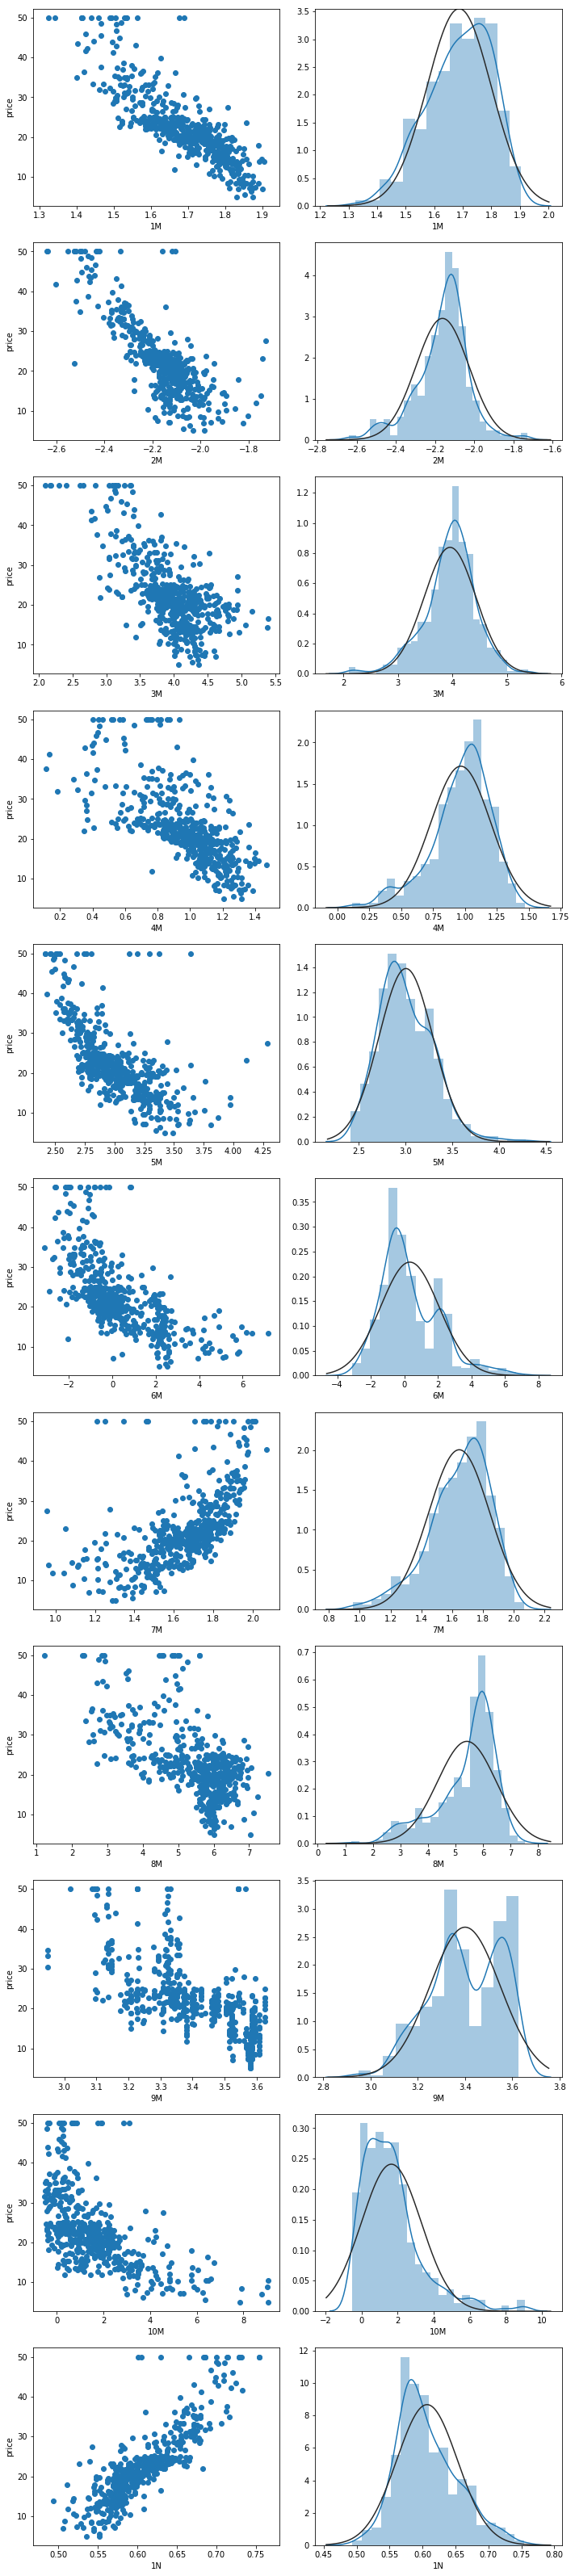

In [51]:
train_new_feature_34 = pd.concat([x_train, train_new_feature_3, train_new_feature_4], axis=1)
test_new_feature_34 = pd.concat([x_test, test_new_feature_3, test_new_feature_4], axis=1)

print(train_new_feature_34.shape)

new_data_34 = pd.concat([train_new_feature_34, test_new_feature_34], axis=0)
new_data_34 = pd.concat([new_data_34, data['TARGET']], axis=1)

features_34 = new_feature_name_M + new_feature_name_N

plot_dist(new_data_34, new_feature_name_M + new_feature_name_N)

In [52]:
corr_34 = new_data_34[new_feature_name_M + new_feature_name_N + ['TARGET']].corr('spearman')

In [53]:
corr_34

,1M,2M,3M,4M,5M,6M,7M,8M,9M,10M,1N,TARGET
1M,1.000000,0.801092,0.630303,0.869145,0.747582,0.812213,-0.783988,0.637961,0.726987,0.784685,-0.969454,-0.869807
2M,0.801092,1.000000,0.609169,0.736713,0.711906,0.638700,-0.746010,0.559808,0.480009,0.589265,-0.907086,-0.745088
3M,0.630303,0.609169,1.000000,0.744363,0.357113,0.576114,-0.180705,0.470488,0.199736,0.329278,-0.630063,-0.593618
4M,0.869145,0.736713,0.744363,1.000000,0.549883,0.709299,-0.587493,0.400340,0.421000,0.611070,-0.847173,-0.751406
5M,0.747582,0.711906,0.357113,0.549883,1.000000,0.780757,-0.816003,0.485207,0.702986,0.647419,-0.779370,-0.741520
6M,0.812213,0.638700,0.576114,0.709299,0.780757,1.000000,-0.680943,0.541632,0.642552,0.648821,-0.783636,-0.742074
7M,-0.783988,-0.746010,-0.180705,-0.587493,-0.816003,-0.680943,1.000000,-0.462278,-0.715611,-0.703480,0.815749,0.715780
8M,0.637961,0.559808,0.470488,0.400340,0.485207,0.541632,-0.462278,1.000000,0.526883,0.596754,-0.627915,-0.566844
9M,0.726987,0.480009,0.199736,0.421000,0.702986,0.642552,-0.715611,0.526883,1.000000,0.674221,-0.690319,-0.675513
10M,0.784685,0.589265,0.329278,0.611070,0.647419,0.648821,-0.703480,0.596754,0.674221,1.000000,-0.746019,-0.651896


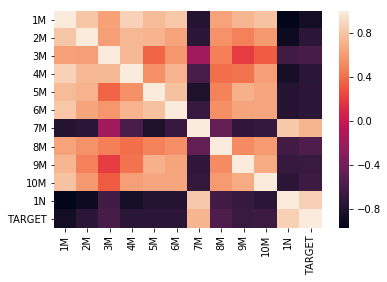

In [54]:
sns.heatmap(corr_34)

In [55]:
alphas = [0.001, 0.005, 0.01, 0.05, 0.1, 0.3, 0.5, 0.7, 1]
for alpha in alphas:
    metrics, fi = Preds(train_new_feature_34, y_train, test_new_feature_34, y_test, alpha)
    print('\n{}'.format(alpha))
    print(metrics)

# 验证集上 0.01最优
metrics, fi = Preds(train_new_feature_34, y_train, test_new_feature_34, y_test, 0.01)


0.001
      fold      train      valid       test
0        0  13.046173  13.721993  17.103811
1        1  10.246277  25.974047  17.607318
2        2  12.313008  14.389099  15.984473
3        3  12.811382  12.776094  16.803985
4  overall  12.104210  16.733007  16.874897

0.005
      fold      train      valid       test
0        0  13.212134  13.038344  17.052022
1        1  10.300260  26.091945  17.533031
2        2  12.471427  14.344639  16.030203
3        3  12.875884  13.122476  16.745694
4  overall  12.214926  16.665825  16.840238

0.01
      fold      train      valid       test
0        0  13.401289  12.729824  17.147719
1        1  10.356919  25.810338  17.473478
2        2  12.604374  14.398953  16.052030
3        3  12.951852  13.393118  16.677230
4  overall  12.328608  16.598239  16.837614

0.05
      fold      train      valid       test
0        0  14.435504  13.017233  17.652973
1        1  11.084130  23.664674  17.550031
2        2  13.445647  15.285747  16.192394
3     

In [56]:
metrics

,fold,train,valid,test
0,0,13.401289,12.729824,17.147719
1,1,10.356919,25.810338,17.473478
2,2,12.604374,14.398953,16.052030
3,3,12.951852,13.393118,16.677230
4,overall,12.328608,16.598239,16.837614


In [57]:
fi

,mean
feature,
RM,69.971071
5M,63.184915
1N,19.310066
4M,7.123753
PTRATIO,4.923580
1M,4.586316
B,2.863926
CHAS,2.753929
6M,2.107900


### 结论

| 实验名 |特征数量|验证集分数|测试集分数|
| :---: |:---: |:---: |:---: |
|控制组|13|19.636047  |19.362313|
|||||
|实验一|23| 14.220659  |19.142288|
|||||
|实验二|23|16.628614	|16.854483|
|||||
|实验三|24|16.598239	|16.837614|

性能稍微提升了一点，当然还可以继续增加生成的特征数量看看能不能继续提升，这里就不再继续了。


当然后续还有空值gplearn模型复杂的的操作方式，这里就没有继续研究了，设想一下，如果控制了生成公式的复杂程度，是可以适当提升一下遗传迭代的层数来生成一些保存了多样性的特征的。